In [1]:
import pandas as pd
from PIL import Image

# Open an image file
img = Image.open('C:/Users/u2285811/Downloads/ModerateDemented-20231105T124650Z-001/ModerateDemented/27 (2).jpg')

# Get the dimensions of the image
width, height = img.size

# Display the dimensions
print(f"The image size is: {width} x {height}")

The image size is: 176 x 208


In [1]:
# import system libs
import os
import time
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
# import system libs
import os
import time
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltAC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPool2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

In [4]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    tr_files, tr_classes = define_paths(data_dir+'/train')
    ts_files, ts_classes = define_paths(data_dir+'/test')
    dummy_df = define_df(tr_files, tr_classes)
    ts_df = define_df(ts_files, ts_classes)

    # valid and test dataframe
    strat = dummy_df['labels']
    tr_df, valid_df = train_test_split(dummy_df,  train_size= 0.75, shuffle= True, random_state= 123, stratify= strat)

    return tr_df, valid_df, ts_df

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (300, 300)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    # Initialize an empty list to store batch sizes
    valid_batch_sizes = []

    # Iterate through possible factors of ts_length
    for n in range(1, ts_length + 1):
        if ts_length % n == 0 and ts_length / n <= 80:
            valid_batch_sizes.append(ts_length // n)

    # Sort the valid batch sizes in descending order
    valid_batch_sizes.sort(reverse=True)

    # Choose the largest valid batch size
    test_batch_size = valid_batch_sizes[0]
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        img = tf.image.rot90(img, k=np.random.randint(0, 4))
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=0.1)
        img = img + noise
        return img



    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [7]:
import os
import pandas as pd

In [9]:
data_dir = 'C:/Users/u2285811/OneDrive - University of Huddersfield/project_files/alz_copy'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print('Invalid Input',e)

Found 2518 validated image filenames belonging to 4 classes.
Found 840 validated image filenames belonging to 4 classes.
Found 638 validated image filenames belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

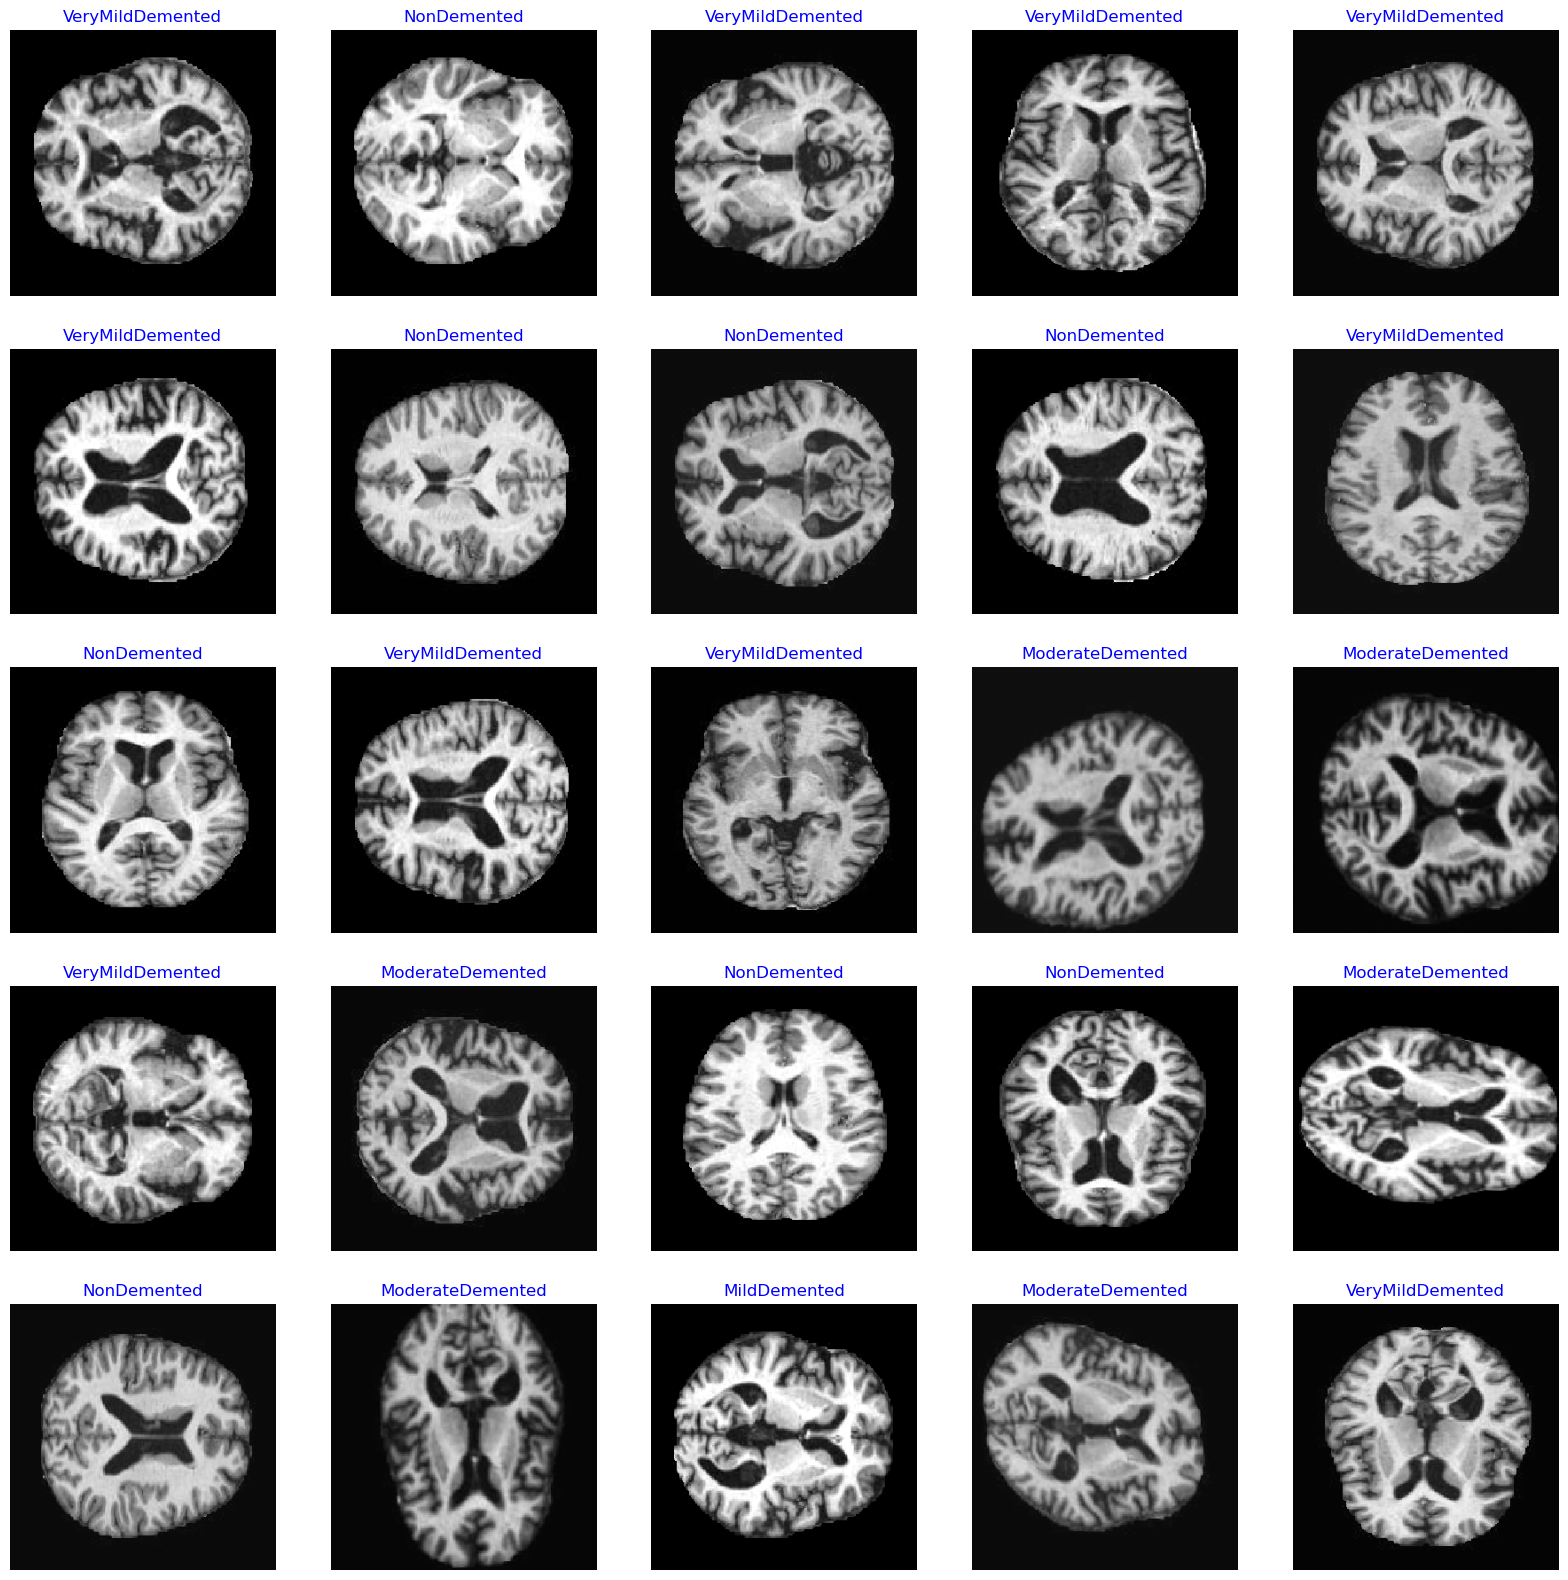

In [16]:
show_images(train_gen)

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [21]:
mobilenet = MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in mobilenet.layers:
    layer.trainable = False
x = Flatten()(mobilenet.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelmnet= Model(inputs=mobilenet.input, outputs=out)

#Compiling
modelmnet.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
#Summary
modelmnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [22]:
# img_size = (300, 300)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)
# class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
# # tf.random.set_seed(123)
# # np.random.seed(123)

# # Create the pre-trained ConvNeXtTiny base model
# base_model = tf.keras.applications.efficientnet.EfficientNetB3(
#     include_top=False,
#     weights='imagenet',
#     input_shape=img_shape,
#     pooling='max',
# )

# # Build the model on top of the base model
# model = Sequential([
#     base_model,
#     Dense(class_count, activation='softmax')
# ])

modelmnet.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [23]:
batch_size=60
epoch=10
callback= keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [46]:
batch_size=60
img_size=(224,224)
image_generator = ImageDataGenerator(rescale=1/255., validation_split=0) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)
train_data = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='C:/Users/u2285811/Downloads/Alzheimer_sDataset/train',
                                                 shuffle=True,
                                                 target_size=img_size,
                                                 subset="training",
                                                 class_mode='categorical')

image_generator = ImageDataGenerator(rescale=1/255,validation_split=0.2)
validation_data= image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory='C:/Users/u2285811/Downloads/Alzheimer_sDataset/test',
                                                 shuffle=True,
                                                 target_size=img_size,
                                                 class_mode='categorical')


submission = image_generator.flow_from_directory(
                                                 directory='C:/Users/u2285811/Downloads/Alzheimer_sDataset/test',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=img_size,
                                                 class_mode=None)

Found 5531 images belonging to 4 classes.
Found 1341 images belonging to 4 classes.
Found 266 images belonging to 4 classes.


In [29]:
hist_mnet=modelmnet.fit(train_data, epochs=25, validation_data=validation_data, callbacks=callback)

Epoch 1/25
93/93 [==============================] - 83s 895ms/step - loss: 0.2918 - accuracy: 0.8874 - val_loss: 1.1360 - val_accuracy: 0.5943
Epoch 2/25
93/93 [==============================] - 48s 520ms/step - loss: 0.2980 - accuracy: 0.8928 - val_loss: 1.2452 - val_accuracy: 0.6704
Epoch 3/25
93/93 [==============================] - 48s 517ms/step - loss: 0.0687 - accuracy: 0.9861 - val_loss: 1.1103 - val_accuracy: 0.7047
Epoch 4/25
93/93 [==============================] - 49s 524ms/step - loss: 0.0269 - accuracy: 0.9993 - val_loss: 1.2372 - val_accuracy: 0.7077
Epoch 5/25
93/93 [==============================] - 49s 529ms/step - loss: 0.0220 - accuracy: 0.9993 - val_loss: 1.3166 - val_accuracy: 0.6972
Epoch 6/25
93/93 [==============================] - 49s 523ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 1.3560 - val_accuracy: 0.7002
Epoch 7/25
93/93 [==============================] - 49s 523ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 1.3346 - val_accuracy: 0.7025

In [30]:
validation_data.classes

array([0, 0, 0, ..., 3, 3, 3])

In [31]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = modelmnet.evaluate(validation_data)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")


23/23 [==============================] - 16s 694ms/step - loss: 1.1103 - accuracy: 0.7047
Validation Accuracy: 0.7046979665756226, Validation Loss: 1.11033296585083


In [32]:
true_labels = validation_data.classes


In [39]:
# Make predictions on the submission dataset
predictions = modelmnet.predict(validation_data)


23/23 [==============================] - 9s 379ms/step


In [35]:
true_labels.shape

(1341,)

In [38]:
predictions

array([[9.9478191e-01, 3.5735736e-06, 4.9243087e-04, 4.7221188e-03],
       [9.7763819e-01, 2.0768000e-07, 1.9768609e-02, 2.5929499e-03],
       [9.7945660e-01, 2.0350033e-07, 4.2816065e-03, 1.6261596e-02],
       ...,
       [3.7606978e-06, 1.9206933e-05, 8.0078214e-01, 1.9919494e-01],
       [4.1708913e-07, 3.3800802e-06, 9.7612202e-01, 2.3874132e-02],
       [4.4111800e-04, 9.2650261e-03, 1.8527523e-01, 8.0501860e-01]],
      dtype=float32)

In [40]:
predictions.shape

(1341, 4)

In [41]:
from sklearn.metrics import confusion_matrix

# Assuming 'true_labels' are the actual labels and 'predictions' are the model's predicted labels
# Replace 'true_labels' and 'predictions' with your actual variables

# Get the true labels
true_labels = validation_data.classes  # If 'validation_data' contains the true labels

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=-1)  # If 'predictions' contains probabilities

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 13   8  97  61]
 [  2   3  42  27]
 [ 24  28 352 236]
 [ 21  21 250 156]]


In [42]:
validation_data.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [44]:
from tensorflow.keras.applications.vgg16 import VGG16

In [45]:
vgg16 = VGG16(input_shape=(224, 224, 3), weights="imagenet", include_top=False)


for layer in vgg16.layers:
    layer.trainable = False


x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
out = Dense(4, activation='softmax')(x)

modelvgg16 = Model(inputs=vgg16.input, outputs=out)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True)

#compiling
modelvgg16.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

#Summary
modelvgg16.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [47]:
hist_vgg=modelvgg16.fit(train_data, epochs=25, validation_data=validation_data, callbacks=callback)

Epoch 1/25
93/93 [==============================] - 249s 3s/step - loss: 1.2656 - accuracy: 0.5966 - val_loss: 0.8195 - val_accuracy: 0.6398
Epoch 2/25
93/93 [==============================] - 261s 3s/step - loss: 0.5629 - accuracy: 0.7622 - val_loss: 0.7952 - val_accuracy: 0.6547
Epoch 3/25
93/93 [==============================] - 319s 3s/step - loss: 0.3989 - accuracy: 0.8530 - val_loss: 0.6993 - val_accuracy: 0.7032
Epoch 4/25
93/93 [==============================] - 346s 4s/step - loss: 0.3559 - accuracy: 0.8599 - val_loss: 0.8799 - val_accuracy: 0.6771
Epoch 5/25
93/93 [==============================] - 336s 4s/step - loss: 0.2236 - accuracy: 0.9349 - val_loss: 0.7057 - val_accuracy: 0.7002
Epoch 6/25
93/93 [==============================] - 263s 3s/step - loss: 0.1856 - accuracy: 0.9481 - val_loss: 0.7146 - val_accuracy: 0.7136
Epoch 7/25
93/93 [==============================] - 261s 3s/step - loss: 0.1552 - accuracy: 0.9593 - val_loss: 0.8940 - val_accuracy: 0.6861
Epoch 8/25
93

In [50]:
validation_loss, validation_accuracy = modelvgg16.evaluate(validation_data)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")

23/23 [==============================] - 52s 2s/step - loss: 0.6993 - accuracy: 0.7032
Validation Accuracy: 0.7032065391540527, Validation Loss: 0.6992856860160828


In [51]:
modelmnet.save('model_net.h5')

In [52]:
modelvgg16.save('vgg16.h5')

In [53]:
data_dir = 'C:/Users/u2285811/Downloads/Alzheimer_sDataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print('Invalid Input',e)

Found 4148 validated image filenames belonging to 4 classes.
Found 1383 validated image filenames belonging to 4 classes.
Found 1341 validated image filenames belonging to 4 classes.


In [55]:
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
# tf.random.set_seed(123)
# np.random.seed(123)

# Create the pre-trained ConvNeXtTiny base model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max',
)

# Build the model on top of the base model
model = Sequential([
    base_model,
    Dense(class_count, activation='softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_7 (Dense)             (None, 4)                 6148      
                                                                 
Total params: 10789683 (41.16 MB)
Trainable params: 10702380 (40.83 MB)
Non-trainable params: 87303 (341.03 KB)
_________________________________________________________________


In [57]:
# batch_size = 40   # set batch size for training
epochs = 10   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 5   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 10   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch



In [60]:
history = model.fit(x= train_gen, epochs= epochs, callbacks= callback,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/10
104/104 [==============================] - 1134s 11s/step - loss: 1.0192 - accuracy: 0.5610 - val_loss: 1.3715 - val_accuracy: 0.4114
Epoch 2/10
104/104 [==============================] - 1137s 11s/step - loss: 0.7886 - accuracy: 0.6203 - val_loss: 0.7818 - val_accuracy: 0.6233
Epoch 3/10
104/104 [==============================] - 1139s 11s/step - loss: 0.7049 - accuracy: 0.6594 - val_loss: 0.8193 - val_accuracy: 0.5813
Epoch 4/10
104/104 [==============================] - 1135s 11s/step - loss: 0.6287 - accuracy: 0.7134 - val_loss: 1.3325 - val_accuracy: 0.4960
Epoch 5/10
104/104 [==============================] - 1134s 11s/step - loss: 0.5816 - accuracy: 0.7478 - val_loss: 0.6660 - val_accuracy: 0.6753
Epoch 6/10
104/104 [==============================] - 1143s 11s/step - loss: 0.4844 - accuracy: 0.8023 - val_loss: 0.7188 - val_accuracy: 0.7368
Epoch 7/10
104/104 [==============================] - 1135s 11s/step - loss: 0.4450 - accuracy: 0.8127 - val_loss: 0.7102 - val_ac

In [66]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    '''
    This function plot confusion matrix method from sklearn package.
    '''

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [64]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 3 ... 2 3 3]


Confusion Matrix, Without Normalization
[[ 67   0  47  65]
 [  3  69   0   2]
 [  3   0 513 124]
 [ 11   0 108 329]]
                  precision    recall  f1-score   support

    MildDemented       0.80      0.37      0.51       179
ModerateDemented       1.00      0.93      0.97        74
     NonDemented       0.77      0.80      0.78       640
VeryMildDemented       0.63      0.73      0.68       448

        accuracy                           0.73      1341
       macro avg       0.80      0.71      0.73      1341
    weighted avg       0.74      0.73      0.72      1341



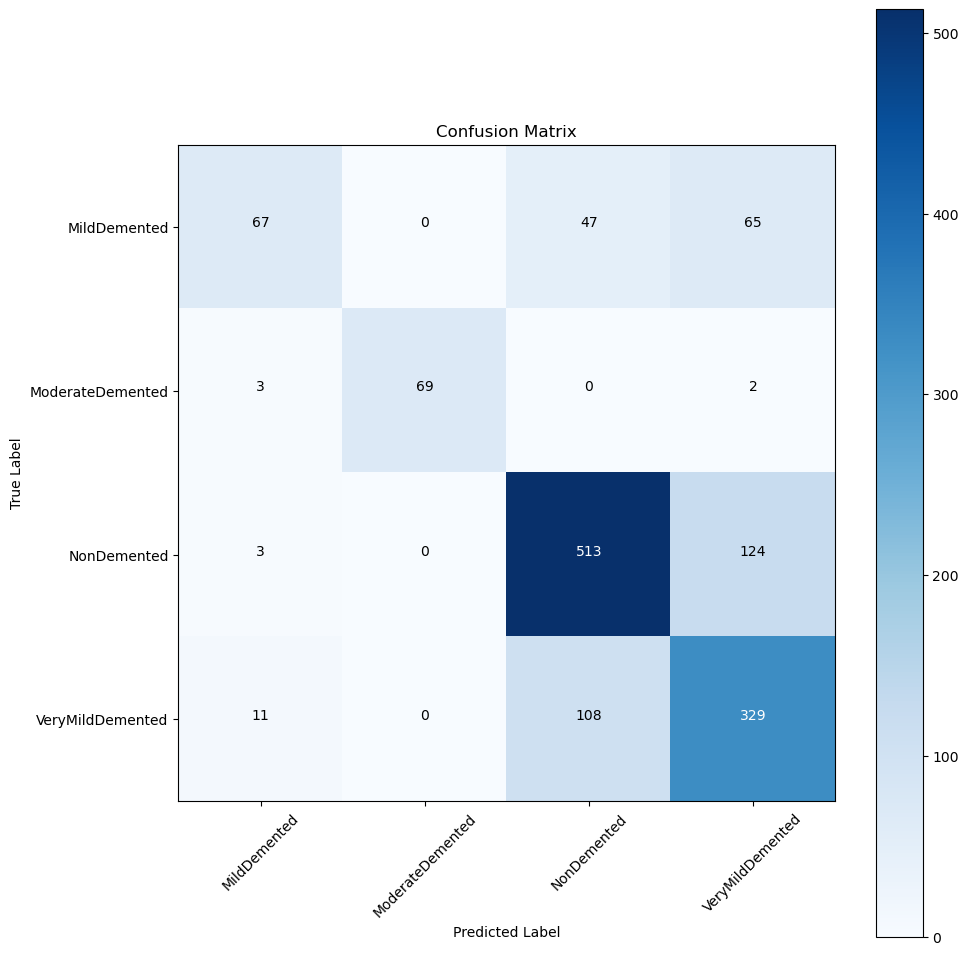

In [67]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [63]:
model

In [68]:
validation_loss, validation_accuracy = model.evaluate(test_gen)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")

149/149 [==============================] - 87s 581ms/step - loss: 0.8352 - accuracy: 0.7293
Validation Accuracy: 0.7293064594268799, Validation Loss: 0.8352166414260864


In [69]:
validation_loss, validation_accuracy = model.evaluate(valid_gen)

print(f"Validation Accuracy: {validation_accuracy}, Validation Loss: {validation_loss}")

35/35 [==============================] - 73s 2s/step - loss: 0.5158 - accuracy: 0.8416
Validation Accuracy: 0.8416485786437988, Validation Loss: 0.5157822966575623


In [ ]:
model

In [70]:
model.save('efficinet.h5')